In [1]:
import random
import math
from collections import defaultdict
import string
from pathlib import Path
import json
import shutil

In [28]:
version_t = tuple[int, int, int]

class GraphGenerator:
    def __init__(self, seed=0):
        self.n_libs = 26
        self.max_depth = 10
        random.seed(a=seed, version=2)

    def make_version(self):
        return (
            math.floor(random.gammavariate(3, 0.6)),
            math.floor(random.gammavariate(3, 0.6)),
            math.floor(random.gammavariate(3, 0.6)),
        )
    
    def make_versions(self, name):
        nb_versions = math.ceil(random.gammavariate(6, 0.3))
        return [
            self.make_version() for _ in range(nb_versions)
        ]
        
    def make_deps_by_name(self) -> dict[str, list[str]]:
        names = string.ascii_uppercase
        names_by_depth: dict[int, str] = defaultdict(list)
        depth_by_name = {}
        for name in names:
            depth = random.randrange(self.max_depth)
            names_by_depth[depth].append(name)
            depth_by_name[name] = depth

        print(depth_by_name)
        deps_by_name = {}
        for name in names:
            possible_deps = [
                dep 
                for depth, deps in names_by_depth.items()
                for dep in deps
                if depth < depth_by_name[name]
            ]
            nb_deps = min(
                math.floor(
                    random.gammavariate(2.5, 0.8)
                ),
                len(possible_deps)
            )
            deps_by_name[name] = random.sample(possible_deps, nb_deps)
        return deps_by_name

    def make_lib_tree_with_versions(self) -> dict[tuple[str, version_t], list[tuple[str, version_t]]]:
        deps_by_name = self.make_deps_by_name()
        versions_by_name = {
            name: self.make_versions(name)
            for name in deps_by_name.keys()
        }
        lib_tree_with_versions = {
            (name, version): [
                (dep, random.choice(versions_by_name[dep]))
                for dep in deps
            ]
            for name, deps in deps_by_name.items()
            for version in versions_by_name[name]
        }
        return lib_tree_with_versions

    def serialize_version(self, version):
        return "v" + ".".join(str(v) for v in version)
        
    def serialize_lib(self, name: str, version: version_t) -> dict[str, str]:
        return {
            "name": name,
            "version": self.serialize_version(version)
        }
    
    def graph_to_disk(self, root_path: Path):
        if root_path.exists():
            shutil.rmtree(root_path)
        root_path.mkdir(exist_ok=True)
        all_versions = defaultdict(list)
        for (name, version), deps in self.make_lib_tree_with_versions().items():
            data = {
                **self.serialize_lib(name, version),
                "dependencies": [
                    self.serialize_lib(dep_name, dep_version)
                    for dep_name, dep_version in deps
                ]
            }
            path = root_path / name / (data["version"] + ".json")
            path.parent.mkdir(exist_ok=True)
            path.write_text(json.dumps(data, indent=2))
            all_versions[name].append(version)

        for name, versions in all_versions.items():
            data = {
                "name": name,
                "versions": [
                    {
                        "version": self.serialize_version(version),
                        "href": f"./{name}/{self.serialize_version(version)}.json"
                    } for version in versions
                ]
            }
            path = root_path / f"{name}.json"
            path.write_text(json.dumps(data, indent=2))
        
        data = [{
            "name": name,
            "href": f"./{name}.json"
        } for name in all_versions.keys()]
        path = root_path  / "all.json"
        path.write_text(json.dumps(data, indent=2))

In [29]:
GraphGenerator().make_lib_tree_with_versions()

{'A': 6, 'B': 6, 'C': 0, 'D': 4, 'E': 8, 'F': 7, 'G': 6, 'H': 4, 'I': 7, 'J': 5, 'K': 9, 'L': 3, 'M': 8, 'N': 2, 'O': 4, 'P': 2, 'Q': 1, 'R': 9, 'S': 4, 'T': 8, 'U': 9, 'V': 2, 'W': 4, 'X': 1, 'Y': 1, 'Z': 5}


{('A', (2, 0, 0)): [('J', (2, 1, 0))],
 ('A', (0, 0, 2)): [('J', (0, 2, 0))],
 ('A', (2, 2, 0)): [('J', (2, 1, 0))],
 ('B', (0, 2, 1)): [('O', (1, 3, 2))],
 ('B', (2, 3, 0)): [('O', (1, 3, 2))],
 ('C', (0, 4, 1)): [],
 ('C', (0, 1, 2)): [],
 ('D', (1, 2, 4)): [],
 ('D', (0, 2, 0)): [],
 ('E', (1, 2, 4)): [('A', (2, 0, 0))],
 ('E', (3, 0, 2)): [('A', (2, 2, 0))],
 ('E', (4, 0, 3)): [('A', (0, 0, 2))],
 ('F', (7, 0, 0)): [('Z', (1, 1, 2)), ('S', (1, 1, 0))],
 ('F', (2, 2, 1)): [('Z', (2, 3, 1)), ('S', (2, 4, 0))],
 ('G', (0, 1, 3)): [('D', (1, 2, 4)), ('O', (1, 3, 1)), ('N', (1, 1, 0))],
 ('G', (0, 0, 1)): [('D', (1, 2, 4)), ('O', (1, 3, 1)), ('N', (1, 1, 0))],
 ('H', (3, 2, 2)): [('N', (1, 1, 0))],
 ('H', (1, 0, 1)): [('N', (1, 1, 0))],
 ('I', (1, 1, 2)): [('G', (0, 0, 1)),
  ('Z', (1, 1, 2)),
  ('Q', (2, 0, 2)),
  ('B', (2, 3, 0))],
 ('I', (0, 4, 1)): [('G', (0, 0, 1)),
  ('Z', (1, 1, 2)),
  ('Q', (1, 3, 1)),
  ('B', (0, 2, 1))],
 ('J', (2, 1, 0)): [('D', (1, 2, 4))],
 ('J', (0, 2, 0))

In [26]:
dest = Path("..") / ".." / "git_data" / "deps"
dest.resolve()

PosixPath('/home/sapristi/dev/git_data/deps')

In [27]:
GraphGenerator().graph_to_disk(dest)

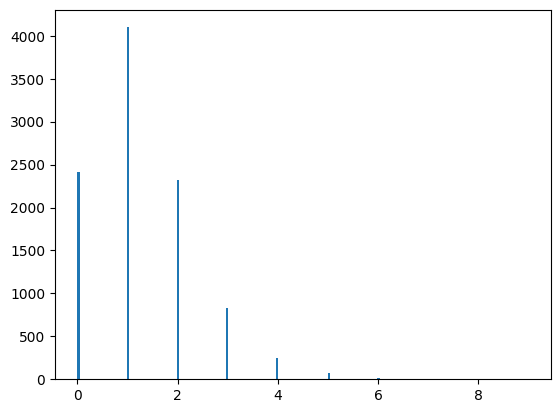

In [24]:
import math
# import the required libraries  
import random  
import matplotlib.pyplot as plt  
    
# store the random numbers in a list  
nums = []  
alpha = 9
beta = 0.5
    
for i in range(10000):  
    temp = math.floor(random.gammavariate(3, 0.6))
    nums.append(temp)  
        
# plotting a graph  
plt.hist(nums, bins = 200)  
plt.show() 
